In [16]:
import pandas as pd
import numpy as np
from gensim import models
import matplotlib.pyplot as plt
import logging
import re
import os
from gensim import corpora
### choose the callbacks classes to import
from gensim.models.callbacks import PerplexityMetric, ConvergenceMetric, CoherenceMetric
from gensim.models import CoherenceModel

In [17]:
def extract_lda_params(data_set):
    """
    :param data_set: pandas dataframe object , each entry is a document
    :return:
          texts_data: list of lists where each inner-list represent a single document : [[dog,cat,mouse],[..],[..]]
          corpus:Gensim corpus parameter for creating the LDA model
          id2word:Gensim dictionary parameter for creating the LDA model
    """
    texts_data = [str(x).split() for x in np.squeeze(data_set).values.tolist()]
    id2word = corpora.Dictionary(texts_data)
    # filter words which appear in less than 10 documents , or in more than 50% of the documents
    id2word.filter_extremes(no_below=10, no_above=0.5)
    corpus = [id2word.doc2bow(text) for text in texts_data]
    return texts_data, corpus, id2word


In [18]:
# The filename is the file that will be created with the log.
# If the file already exists, the log will continue rather than being overwritten.
from importlib import reload  # Not needed in Python 2
import logging
reload(logging)
logging.basicConfig(filename=r'C:\Users\katac\PycharmProjects\NLP_project\TopicModeling\LDA\src\model_callbacks_passes.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

In [19]:
train_data_path = r'C:\Users\katac\PycharmProjects\NLP_project\TopicModeling\LDA\data\hod_clean_lda_train.csv'
training_set = pd.read_csv(train_data_path, encoding='utf8')
documents,corpus,dictionary = extract_lda_params(training_set)

In [7]:
# Set up the callbacks loggers
coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = documents)

In [20]:
    # List of the different iterations to try
    passes = range(60,100,20)

    # The number of passes to use - could change depending on requirements

    for i in passes:

        # Add text to logger to indicate new model
        logging.debug(f'Start of model: {i} passes')

        # Create model - note callbacks argument uses list of created callback loggers
        curr_lda_model = models.ldamodel.LdaModel(corpus=corpus,
                 id2word=dictionary,
                 num_topics=16,
                 update_every=1,
                chunksize=300,
                 passes=i,
                 iterations=250,
                random_state=42)
        coherencemodel = models.CoherenceModel(
                    model=curr_lda_model, texts=documents, corpus=corpus,
                    dictionary=dictionary,coherence='c_v')
        logging.debug(f"c_v coherence : {coherencemodel.get_coherence()}")
        # Add text to logger to indicate end of this model
        logging.debug(f'End of model: {i} passes')


KeyboardInterrupt: 

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 25, 35, 45, 60, 80]
[0.484, 0.492, 0.49, 0.487, 0.489, 0.49, 0.491, 0.492, 0.492, 0.492, 0.493, 0.493, 0.49, 0.491, 0.491, 0.491, 0.491]


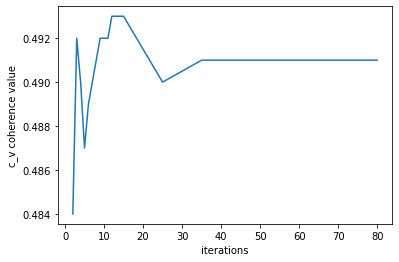

In [2]:
import matplotlib.pyplot as plt
iteration=[]
perplexity=[]
convergence=[]
coherence=[]
for line in open(r'C:\Users\katac\PycharmProjects\NLP_project\TopicModeling\LDA\src\model_callbacks_passes.log'):
    if 'Start' in line:
        short=" ".join(line.split()[:-1])
        iteration.append(short.split()[-1])
    if 'coherence' in line :
        coherence.append(line.split()[-1])

fields = ['iterations','cv_coherence']
# rows = zip(iteration,coherence)
# with open("conv.csv","w") as f :
#     writer = csv.writer(f)
#     writer.writerow(fields)
#     for row in rows:
#         writer.writerow(row)

iteration = [ int(i) for i in iteration]
coherence = [round(float(i),3) for i in coherence]
print(iteration)
print(coherence)
plt.plot(iteration,coherence)
plt.xlabel("iterations")
plt.ylabel("c_v coherence value")
plt.show()